In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import utils
import os

In [4]:
data = pd.read_csv("../data/UCF-crime-frames-descriptions-partitions.csv")

In [5]:
data.head(2)

,Unnamed: 0,frame,directory,class,Description,partition
0,0,Abuse001_x264.mp4_frame_000000.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train
1,1,Abuse001_x264.mp4_frame_000010.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train


In [6]:
train = data.loc[data["partition"] == "train"]
val = data.loc[data["partition"] == "validation"]
test = data.loc[data["partition"] == "test"]

In [7]:
path = "d:/data/UCF-crime/Anomaly-Videos-description-features-mean"
if os.path.isfile("../data/train_desc_mean.npy"):
    print("Loading bulk")
    X = np.load("../data/train_desc_mean.npy")
    V = np.load("../data/val_desc_mean.npy")
    X = torch.tensor(X, dtype=torch.float32)
    V = torch.tensor(V, dtype=torch.float32)
    y = list(train["class"])
    y = np.array([utils.labels[lbl] for lbl in y])
    y = torch.tensor(y, dtype=torch.float32)
    y_val = list(val["class"])
    y_val = np.array([utils.labels[lbl] for lbl in y_val])
    y_val = torch.tensor(y_val, dtype=torch.float32)
else:
    print("Loading individually")
    V, y_val = utils.get_data(val, path, n=2560)
    X, y = utils.get_data(train, path, n=2560)
    np.save( "../data/train_desc_mean.npy", X.numpy())
    np.save( "../data/val_desc_mean.npy", V.numpy())

Loading bulk


In [8]:
labels_counts = torch.tensor([(y==i).sum() for i in range(len(utils.labels))])
weights = 1 - labels_counts / len(X)    

In [9]:
model = nn.Sequential(
    nn.Linear(2560, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

In [10]:
sum(param.numel() for param in model.parameters())

921098

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Sequential(
  (0): Linear(in_features=2560, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=10, bias=True)
)

In [12]:
weights = weights.to(device)
loss_fn = nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [13]:
n_epochs = 30
batch_size = 64
for epoch in range(n_epochs):
    acc = 0
    perm = torch.randperm(len(X))
    for i in range(0, len(X), batch_size):
        Xbatch = X[perm[i:i+batch_size]]
        Xbatch = Xbatch.to(device)
        y_pred = model(Xbatch)
        ybatch = y[perm[i:i+batch_size]]
        ybatch = ybatch.type(torch.LongTensor)
        ybatch = ybatch.to(device)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc += utils.get_acc(y_pred, ybatch, return_sum=True)
    val_pred = utils.evaluate(V, model, device, batch_size)
        
    print(f'Finished epoch {epoch}, latest loss {loss}, acc {acc/len(X)} val_acc {utils.get_acc(val_pred, y_val)}')

Finished epoch 0, latest loss 1.7907453775405884, acc 0.6746869087219238 val_acc 0.6790998578071594
Finished epoch 1, latest loss 1.5015246868133545, acc 0.6857465505599976 val_acc 0.674702525138855
Finished epoch 2, latest loss 1.2848594188690186, acc 0.6982077956199646 val_acc 0.6617692708969116
Finished epoch 3, latest loss 1.0176572799682617, acc 0.7015023231506348 val_acc 0.6494050621986389
Finished epoch 4, latest loss 1.2399070262908936, acc 0.7021628022193909 val_acc 0.6186239123344421
Finished epoch 5, latest loss 1.1996674537658691, acc 0.7049821019172668 val_acc 0.6530781388282776
Finished epoch 6, latest loss 0.8174660801887512, acc 0.70513516664505 val_acc 0.6304190158843994
Finished epoch 7, latest loss 1.1556874513626099, acc 0.7073019742965698 val_acc 0.644749104976654
Finished epoch 8, latest loss 1.3116918802261353, acc 0.7082121968269348 val_acc 0.6503880023956299
Finished epoch 9, latest loss 0.8250411748886108, acc 0.7092512845993042 val_acc 0.6514226794242859
Fini

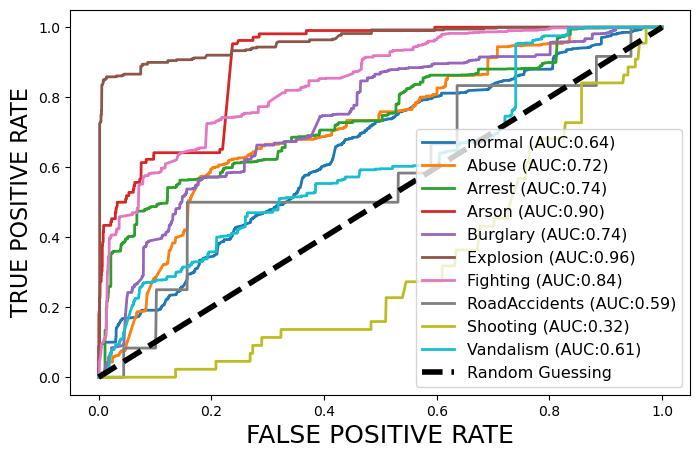

ROC AUC score: 0.706745333028377


In [14]:
print('ROC AUC score:', utils.multiclass_roc_auc_score(y_val , val_pred, average = "macro"))

In [15]:
utils.get_acc_per_lbl(val_pred, y_val)

0, presc 0.73, recall 0.76, f1 0.74	 total 12895 Normal
1, presc 0.21, recall 0.04, f1 0.06	 total 646 Abuse
2, presc 0.53, recall 0.36, f1 0.43	 total 1321 Arrest
3, presc 0.08, recall 0.42, f1 0.14	 total 106 Arson
4, presc 0.22, recall 0.25, f1 0.23	 total 1767 Burglary
5, presc 0.77, recall 0.72, f1 0.75	 total 388 Explosion
6, presc 0.26, recall 0.42, f1 0.32	 total 1132 Fighting
7, presc nan, recall 0.00, f1 nan	 total 12 RoadAccidents
8, presc nan, recall 0.00, f1 nan	 total 44 Shooting
9, presc 0.10, recall 0.02, f1 0.04	 total 1019 Vandalism


In [16]:
utils.get_acc(val_pred, y_val)

tensor(0.5961)

In [17]:
X_pred = utils.evaluate(X, model, device, batch_size)

In [18]:
utils.get_acc_per_lbl(X_pred, y)

0, presc 0.84, recall 0.82, f1 0.83	 total 84684 Normal
1, presc 0.56, recall 0.17, f1 0.26	 total 2593 Abuse
2, presc 0.60, recall 0.76, f1 0.67	 total 10454 Arrest
3, presc 0.52, recall 0.51, f1 0.52	 total 4984 Arson
4, presc 0.50, recall 0.69, f1 0.58	 total 8211 Burglary
5, presc 0.59, recall 0.56, f1 0.58	 total 2138 Explosion
6, presc 0.48, recall 0.63, f1 0.54	 total 6178 Fighting
7, presc nan, recall 0.00, f1 nan	 total 689 RoadAccidents
8, presc nan, recall 0.00, f1 nan	 total 1568 Shooting
9, presc 0.43, recall 0.23, f1 0.30	 total 2646 Vandalism


In [19]:
utils.get_acc(X_pred, y)

tensor(0.7362)

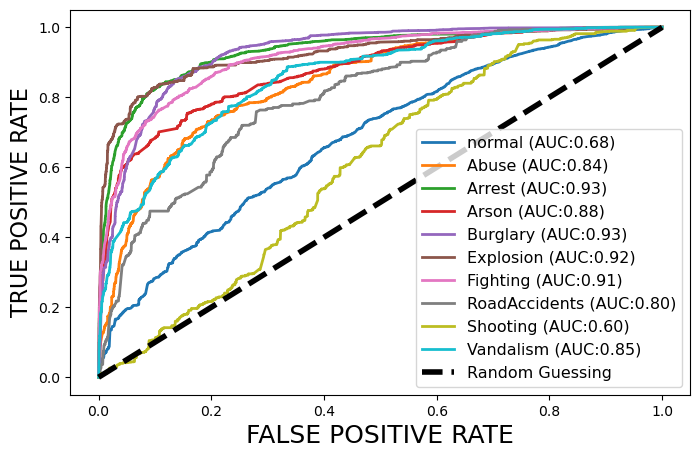

ROC AUC score: 0.8354221143164647


In [20]:
print('ROC AUC score:', utils.multiclass_roc_auc_score(y , X_pred, average = "macro"))

In [21]:
torch.save(model.state_dict(), "models/model_image_desc_features.pt")